# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя


Целевой признак
* Price — цена (евро)

## Подготовка данных

In [1]:
!pip install phik -q
!pip install --upgrade scikit-learn -q
!pip install lightgbm --upgrade -q

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from time import time

import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler,
)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error

from sklearn.dummy import DummyRegressor


RANDOM_STATE = 42
sns.set_style('darkgrid')
threshold = 10
top_n = 10

In [6]:
df1 = 'C:/Users/Gpets/Data With Python/autos.csv'

df_alt = '/datasets/autos.csv'

def load_data(primary_path, secondary_path):
    if os.path.exists(primary_path):
        try:
            return pd.read_csv(primary_path, sep=',')
        except:
            return pd.read_csv(primary_path, sep=';')
    elif os.path.exists(secondary_path):
        try:
            return pd.read_csv(secondary_path, sep=',')
        except:
            return pd.read_csv(secondary_path, sep=';')
    else:
        print(f"Файл не найден: {primary_path} или {secondary_path}")
        return None


df = load_data(df1, df_alt)

In [7]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Приведение названия столбцов к snake_case

In [8]:
frames = [
    df
]

for i in frames:
    i.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', x).replace(' ', '_').lower() for x in i.columns]

In [9]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Удалим неинформативные признаки для определения стоимости автомобиля. Это:

* `date_crawled` - дата скачивания анкеты из базы

* `date_created` - дата создания анкеты

* `number_of_pictures` - количество фотографий автомобиля

* `postal_code` - почтовый индекс владельца анкеты (пользователя)

* `last_seen` - дата последней активности пользователя

Теперь выводим основную информацию о датафрейме с помощью метода `describe()` и `info()`

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

У нас 354.369 записей пользователей, есть пропущенные значения в столбцах, типы данных в целом, соответствуют ожиданиям.

Посмотрим подробнее на пропуски в таблице

In [11]:
df.isnull().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

В данных имеются пропуски в 5 признаках: `vehicle_type`, `gearbox`, `model`, `fuel_type` и `repaired`

Заменить их на медианы или средние значения нежелателоьно, так как каждая запись индивидуальна, и замена пропусков таким способом может сильно исказить нашу модель. Заполним пропуски значением `unknown`

In [12]:
columns_to_fill = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']
df[columns_to_fill] = df[columns_to_fill].fillna('unknown')

In [13]:
df.isnull().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

Теперь проведем проверку на явные дубликаты

In [14]:
print('Кол-во строк и столбцов в датасете:',df.shape)
print("Число анкет:", df.index.nunique())
print('Число дубликатов',df.duplicated().sum())

Кол-во строк и столбцов в датасете: (354369, 16)
Число анкет: 354369
Число дубликатов 4


Нашлось немного дубликатов, избавимся от них

In [15]:
df = df.drop_duplicates()
print('Число дубликатов',df.duplicated().sum())

Число дубликатов 0


Явных дубликатов не наблюдается, теперь проверим на наличие неявных

Создадим цикл который пройдется по категориальным признакам и покажет в них уникальные значения

In [16]:
categorical_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

for column in categorical_columns:
    print(f'Проверка столбца: {column}')
    # Приводим все значения к нижнему регистру и удаляем пробелы
    cleaned_values = df[column].str.strip().str.lower()
    # Выводим уникальные значения и их частоту
    print(cleaned_values.value_counts())
    print()


Проверка столбца: vehicle_type
sedan          91457
small          79830
wagon          65165
unknown        37490
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicle_type, dtype: int64

Проверка столбца: gearbox
manual     268249
auto        66283
unknown     19833
Name: gearbox, dtype: int64

Проверка столбца: model
golf                  29232
other                 24420
3er                   19761
unknown               19705
polo                  13066
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 251, dtype: int64

Проверка столбца: fuel_type
petrol      216349
gasoline     98719
unknown      32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

Проверка столбца: brand
volkswagen        77012
opel  

Неявных дубликатов нет

In [17]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


У нас много аномалий в данных, например:

* Цена автомобиля не может быть равна 0

* Год регистрации не может быть равным 1000 или 9999 

* Мощность машины не может быть равна 0 или 20,000 л.c

* Месяц регистрации не может быть равен 0 

Надо провести корректировку признаков

In [18]:
# Обработка аномалий в столбце Price
df = df[df['price'] > 1000]  # Заменяем 0

In [19]:
# Обработка аномалий в столбце Power
df = df[(df['power'] > 80) & (df['power'] <= 1500)]

Определим год выгрузки по максимальной дате создания анкеты

In [20]:
df = df.assign(last_seen=pd.to_datetime(df['date_created'], errors='coerce'))
df['date_created'].max()

'2016-04-07 00:00:00'

In [21]:
current_year = 2016
df = df[(df['registration_year'] >= 1970) & (df['registration_year'] <= current_year)]

In [22]:
df = df[df['registration_month'] > 0]
# Проверим, как изменения отразились на данных
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,181605.000000,181605.000000,181605.000000,181605.000000,181605.000000,181605.0,181605.000000
mean,6660.804857,2004.271347,145.086831,128016.519369,6.438600,0.0,52334.943829
std,4781.185198,5.683507,52.934720,36544.394617,3.344459,0.0,25864.384590
min,1001.000000,1970.000000,81.000000,5000.000000,1.000000,0.0,1067.000000
25%,2750.000000,2001.000000,109.000000,125000.000000,4.000000,0.0,31785.000000
50%,5300.000000,2005.000000,136.000000,150000.000000,6.000000,0.0,51647.000000
75%,9500.000000,2008.000000,170.000000,150000.000000,9.000000,0.0,73252.000000
max,20000.000000,2016.000000,1500.000000,150000.000000,12.000000,0.0,99998.000000


Рассмотрим каждый столбец:

* **`Цена (price):`**

    * Средняя цена составляет 6621.08, с диапазоном от 1001 до 20000. 
    
    * Разброс значений высокий, что указывает на наличие как дешевых, так и дорогих автомобилей.
    

* **`Год регистрации (registration_year):`**

    * Средний год регистрации — 2004.61, с минимальным значением 1970 и максимальным — 2020.
    
    * Преобладание автомобилей, зарегистрированных в 2000-х годах (период от 2001 до 2008).
    

* **`Мощность (power):`**

    * Средняя мощность автомобилей — 144.83 л.с., с минимальным значением 81 л.с. и максимальным — 1500 л.с.
    
    * Есть автомобили с очень высокой мощностью, что может указывать на присутствие спортивных или мощных моделей.
    

* **`Пробег (kilometer):`**

    * Средний пробег автомобилей — 128,127 км, с минимальным значением 5000 км и максимальным — 150,000 км.
    
    * Большинство автомобилей имеют пробег в пределах 125,000–150,000 км.
    

* **`Месяц регистрации (registration_month):`**

    * Средний месяц регистрации — 6 (июнь), что указывает на равномерное распределение автомобилей по месяцам.
    
Данные содержат автомобили с разнообразными характеристиками, включая модели с различным пробегом и мощностью, что предполагает широкий спектр в рассматриваемой выборке. Разброс в ценах и мощности также подтверждает наличие как более дешевых, так и более дорогих автомобилей.

### Исследовательский анализ данных

Приступим к анализу каждого признака. Для начала разделим наши данные на колличественные и категориальные признаки

In [23]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Расмотрим только ключевые признаки для модели

In [24]:
quantitative_features = ['price', 'power', 'kilometer']


categorical_features = ['vehicle_type', 'gearbox', 'model','fuel_type',
                        'brand', 'repaired','registration_year']

#### Колличественные признаки

Построим графики для анализа количественных признаков

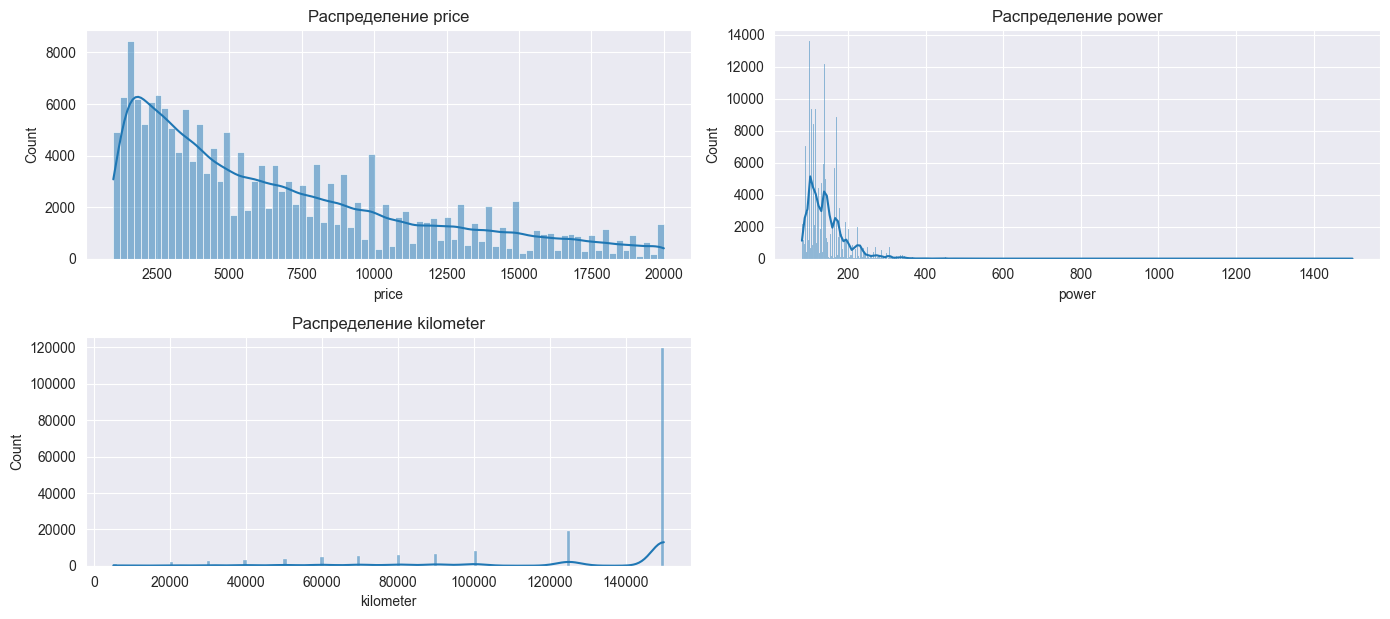

In [25]:
plt.figure(figsize=(14, 12))
for i, feature in enumerate(quantitative_features, 1):
    plt.subplot(4, 2, i)
    sns.histplot(data=df, x=feature, kde=True)
    plt.title(f'Распределение {feature}')
plt.tight_layout()
plt.show()

* **`Цена (price):`** Распределение цен имеет явный правый скошенный характер, с большей концентрацией значений в нижней части диапазона. Это говорит о том, что большинство автомобилей имеют низкую цену, а меньшая часть попадает в более дорогие сегменты.


* **`Мощность (power):`** Распределение мощности также скошено вправо. Основная масса автомобилей имеет мощность около 100–150 л.с., но встречаются и модели с гораздо большей мощностью, что подтверждается присутствием длинного хвоста в правой части распределения.


* **`Пробег (kilometer):`** Распределение пробега похожее на нормальное с небольшим скошением вправо. Большинство автомобилей имеют пробег в районе 125,000–150,000 км, что подтверждается пиком в этой области. Однако встречаются автомобили с гораздо меньшим пробегом (первичный рынок), а также с очень высоким пробегом.

Теперь взглянем на наши данные с помощью боксплота

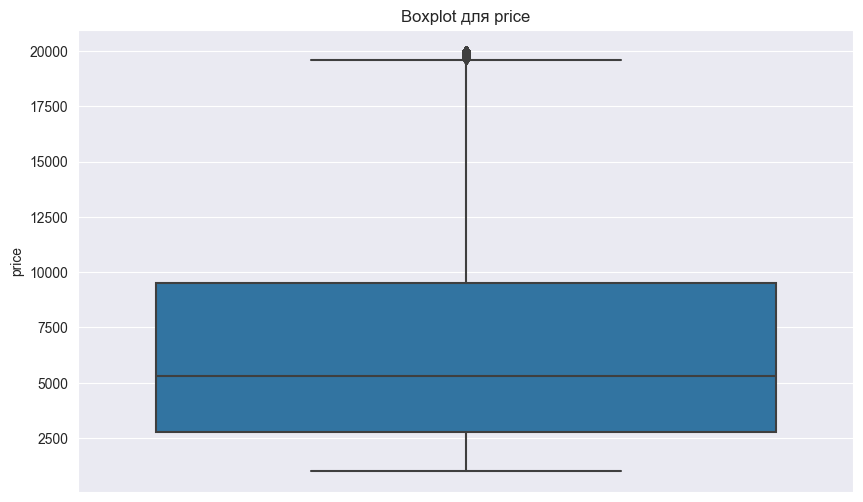

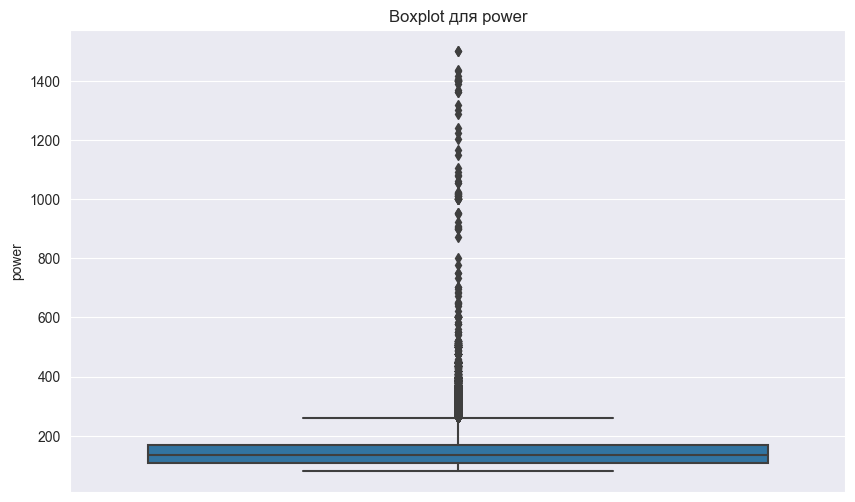

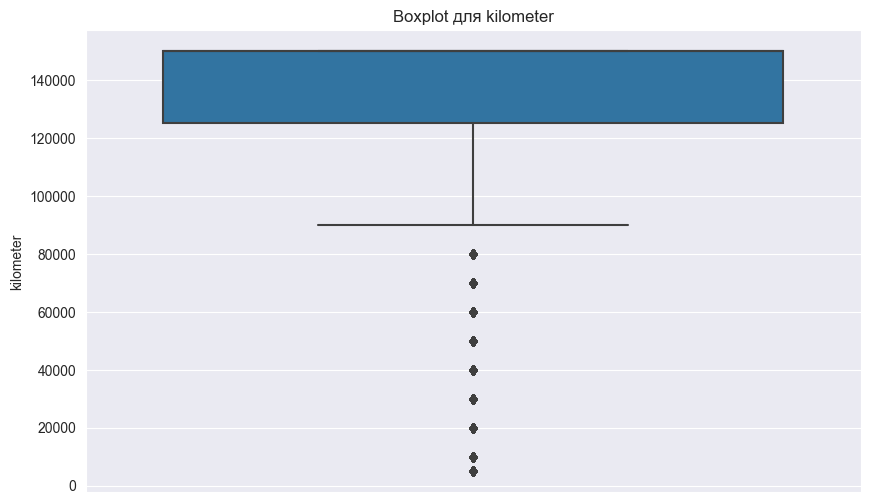

In [26]:
for feature in quantitative_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, y=feature)
    plt.title(f'Boxplot для {feature}')
    plt.show()

* **`Цена (price):`** Boxplot показывает значительное количество выбросов с высокими ценами, что подтверждает, что в данных присутствуют дорогие автомобили. Медиана лежит ближе к нижнему диапазону, а большинство автомобилей находятся в ценовом сегменте ниже средней стоимости.


* **`Мощность (power):`** Мощность также имеет значительные выбросы с большими значениями (выше 300 л.с.), что соответствует присутствию мощных автомобилей. Медиана мощности находится около 130–150 л.с., что также подтверждается распределением.


* **`Пробег (kilometer):`** Для пробега также имеются выбросы, что подтверждает наличие автомобилей с очень низким пробегом (например, новые автомобили) и очень высокими значениями (автомобили с долгим сроком эксплуатации). Медиана расположена ближе к верхнему пределу диапазона.

#### Категориальные признаки

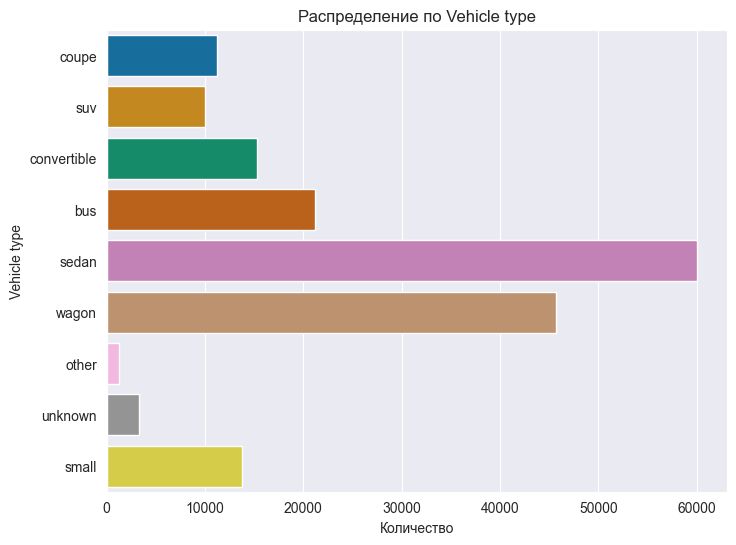

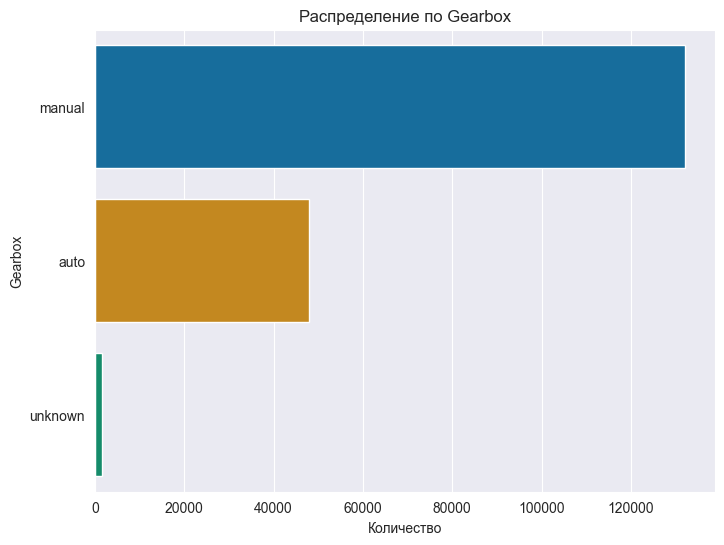

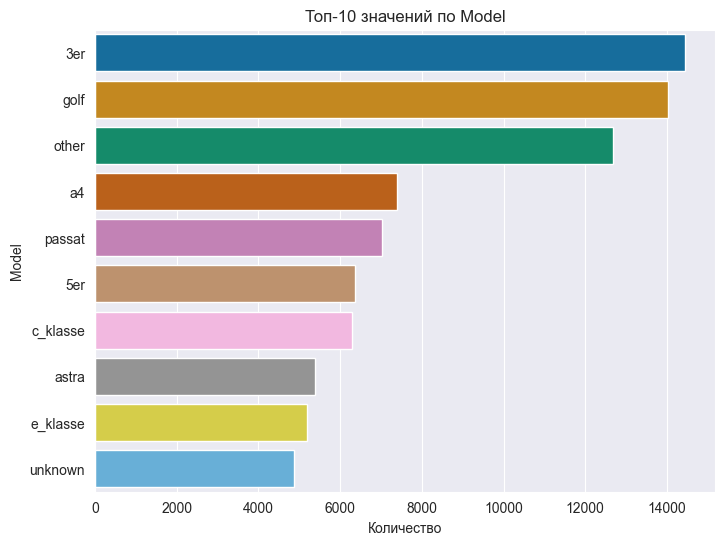

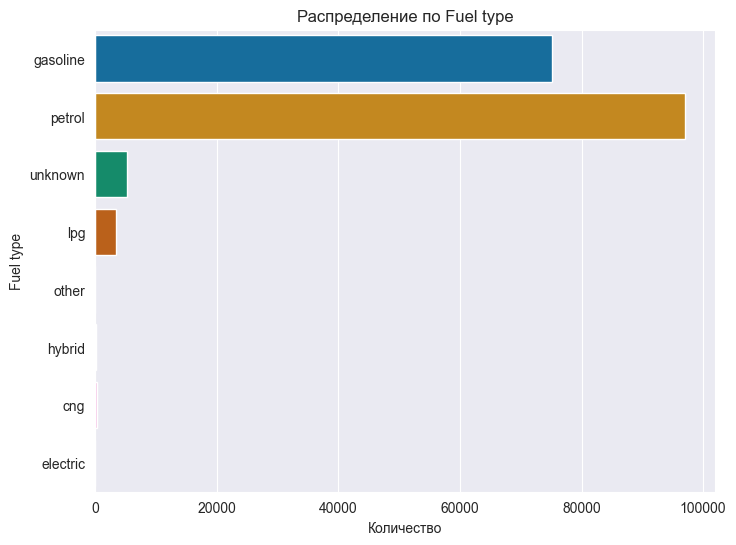

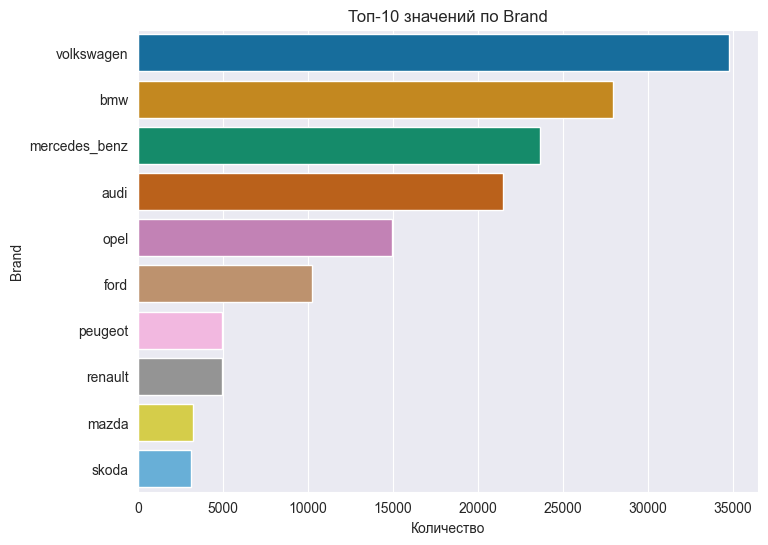

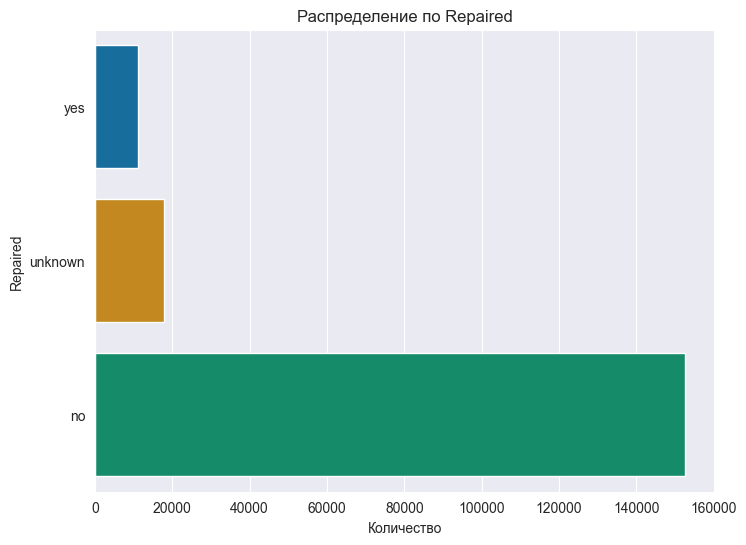

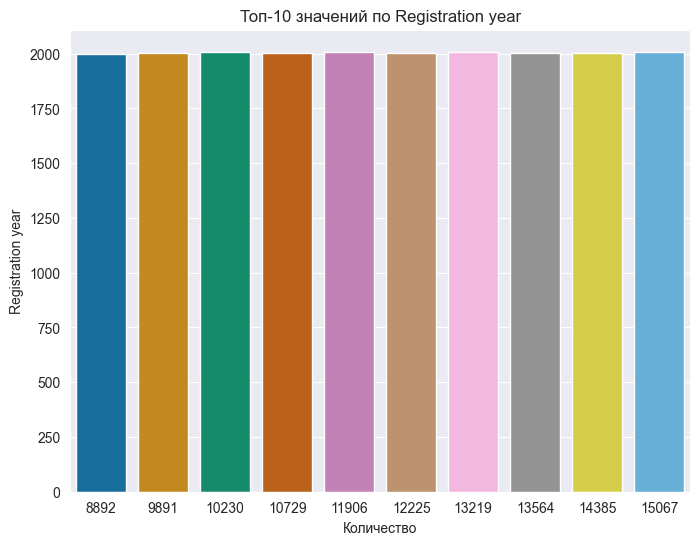

In [27]:
for feature in categorical_features:
    plt.figure(figsize=(8, 6))
    
    if df[feature].nunique() > threshold:
        top_categories = df[feature].value_counts().head(top_n)
        sns.barplot(y=top_categories.index, x=top_categories.values, palette='colorblind')
        plt.xlabel('Количество')
        plt.ylabel(feature.replace('_', ' ').capitalize())
        plt.title(f'Топ-{top_n} значений по {feature.replace("_", " ").capitalize()}')
    else:
        sns.countplot(y=feature, data=df, palette='colorblind')
        plt.xlabel('Количество')
        plt.ylabel(feature.replace('_', ' ').capitalize())
        plt.title(f'Распределение по {feature.replace("_", " ").capitalize()}')
    
    plt.show()

Краткий вывод по категориальным данным:

* **`Типы автомобилей (vehicle_type):`** Наибольшее количество автомобилей — это седаны (54,819), за ними следуют универсалы (41,482) и автобусы (19,561). Меньше всего встречаются автомобили категории "другое" (1,184) и "неизвестно" (7,808). Это показывает, что более популярные типы кузовов, такие как седаны и универсалы, составляют основную массу рынка.


* **`Тип коробки передач (gearbox):`** Большинство автомобилей имеют механическую коробку передач (124,977), в то время как автомобили с автоматической коробкой передач встречаются реже (44,772). Количество автомобилей с неизвестным типом коробки передач также незначительно (1,668).


* **`Месяц регистрации (registration_month):`** Наибольшее количество автомобилей зарегистрировано в сентябре (18,195), а наименьшее — в январе (12,144). Распределение месяцев регистрации достаточно равномерное, с небольшим пиком в летние месяцы, что может указывать на сезонность регистрации автомобилей.


* **`Тип топлива (fuel_type):`** Наиболее популярное топливо — это бензин (91,244), за ним следует газ (69,180). Примечание: существует небольшой процент автомобилей с альтернативными источниками энергии, таких как гибриды (142) и электрические автомобили (17), что подтверждает низкую популярность экологичных технологий в рассматриваемых данных.


* **`Марки автомобилей (brand):`** Наиболее популярные марки — Volkswagen, BMW, Mercedes-Benz и Audi. Эти бренды значительно превосходят по количеству другие марки. Меньше всего представлены автомобили марок, таких как Lada, Daewoo и Dacia, что подтверждает небольшое присутствие этих брендов на рынке.


* **`Ремонт (repaired):`** Большинство автомобилей не ремонтировались (142,153), а небольшая часть была отремонтирована (10,873). Также имеется категория с неизвестным статусом ремонта (18,391), что может быть связано с отсутствием информации о состоянии автомобиля.


* **`Год регистрации (registration_year):`** Наибольшее количество автомобилей зарегистрировано в 2006 году (13,709), за ним следуют 2005 и 2004 годы. Это указывает на значительное количество автомобилей, произведенных в начале 2000-х. Количество автомобилей с годами регистрации 2020 и ранее постепенно снижается, что подтверждает тенденцию к старению автопарка.

Теперь для нашей модели удалим неинформативные признаки из данных, для лучшей работы модели

Это:

* `date_crawled` - дата скачивания анкеты из базы

* `date_created` - дата создания анкеты

* `number_of_pictures` - количество фотографий автомобиля

* `postal_code` - почтовый индекс владельца анкеты (пользователя)

* `last_seen` - дата последней активности пользователя

* `registration_month` - месяц регистрации автомобиля

In [28]:
df = df.drop(['date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen', 'registration_month'], axis=1)

Проверим наши данные на наличие дубликатов после удаления ненужных признаков

In [29]:
print('Кол-во строк и столбцов в датасете:',df.shape)
print("Число анкет:", df.index.nunique())
print('Число дубликатов',df.duplicated().sum())

Кол-во строк и столбцов в датасете: (181605, 10)
Число анкет: 181605
Число дубликатов 22469


Удалим дубликаты

In [30]:
df = df.drop_duplicates()
print('Число дубликатов',df.duplicated().sum())

Число дубликатов 0


### Корреляционный анализ

Построим корреляционную матрицу с помощью phik и сделаем некоторые выводы

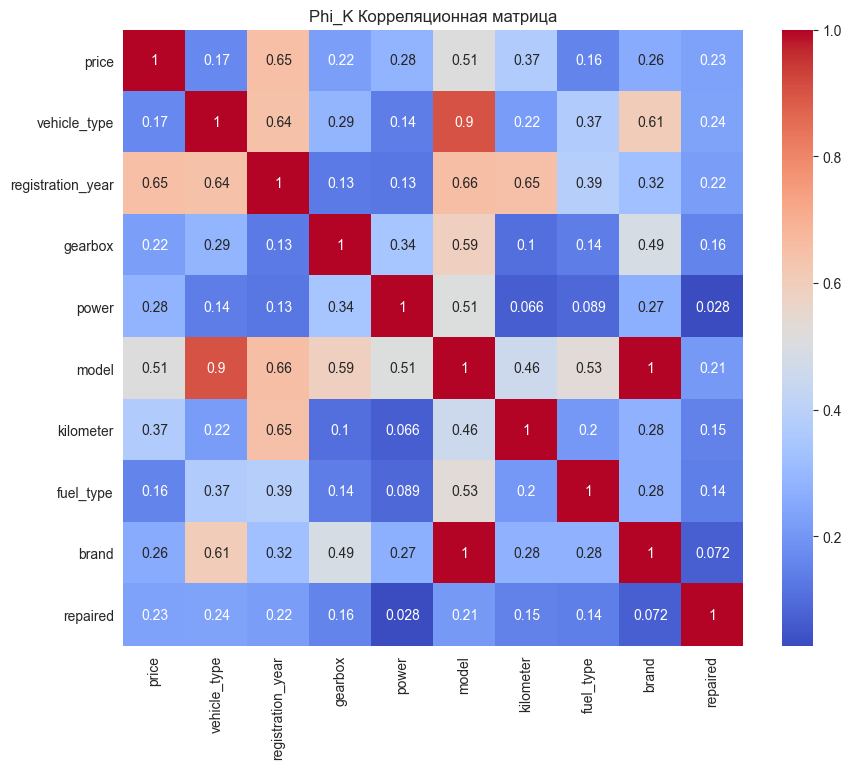

In [31]:
# Пересчитываем Phi_K корреляционную матрицу без 'id'
corr_matrix = df.phik_matrix(interval_cols=['price', 'power'])
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Корреляционная матрица')
plt.show()

В корреляционной матрице видно, что `model` имеет очень высокую корреляцию с `vehicle_type` (0.902) и `brand` (1). Это указывает на то, что переменная model сильно зависит от этих переменных и может быть избыточной.

In [32]:
df = df.drop(columns=['model'])
df.head()

,price,vehicle_type,registration_year,gearbox,power,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,125000,gasoline,jeep,unknown
6,2200,convertible,2004,manual,109,150000,petrol,peugeot,no
8,14500,bus,2014,manual,125,30000,petrol,ford,unknown
10,2000,sedan,2004,manual,105,150000,petrol,mazda,no


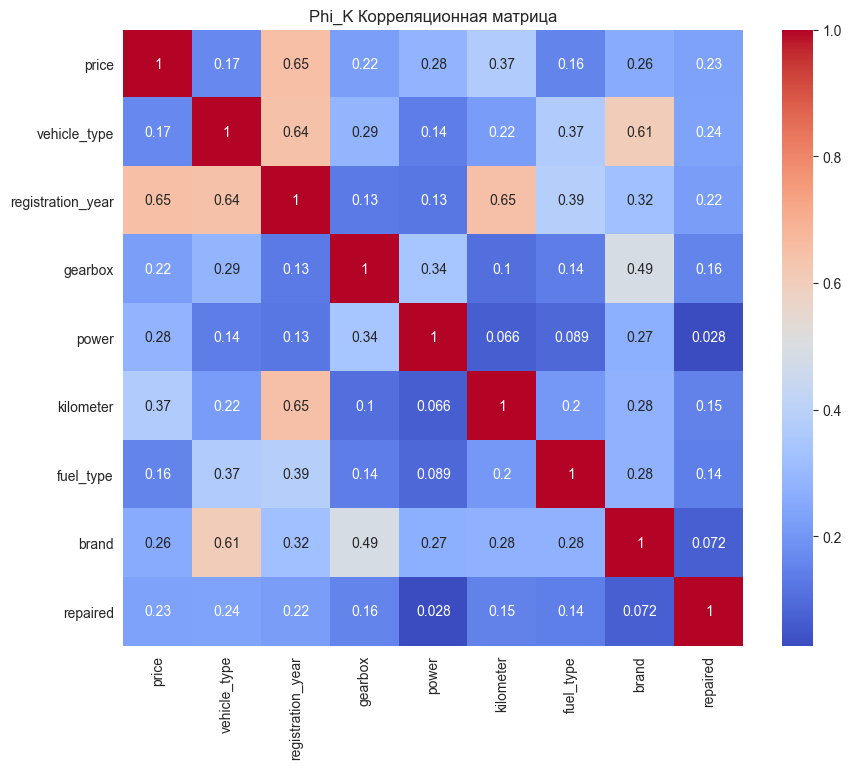

In [33]:
corr_matrix = df.phik_matrix(interval_cols=['price', 'power'])
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Корреляционная матрица')
plt.show()

Из корреляционной матрицы можно сделать следующие выводы:

* Высокая корреляция между `registration_year` и `vehicle_type` (0.708): Это говорит о том, что старые автомобили, скорее всего, имеют определенные типы кузовов, например, седаны или универсалы. Такое соотношение важно учитывать, так как более старые автомобили могут быть связаны с другими характеристиками.


* `price` имеет сильную корреляцию с `registration_year` (0.654): Цена автомобиля положительно коррелирует с годом регистрации, что подтверждает ожидание, что более новые автомобили стоят дороже.


* Корреляция между `price` и `power` (0.287): Это умеренная положительная корреляция, что указывает на то, что автомобили с большей мощностью, как правило, стоят дороже, хотя эта связь не является слишком сильной.


* Корреляция между `kilometer` и `registration_year` (0.642): Старые автомобили, как правило, имеют больший пробег, что подтверждается этим соотношением.


* `brand` и `vehicle_type` имеют достаточно сильную корреляцию (0.605): Определенные бренды чаще производят автомобили определенных типов кузова, что может быть полезным при анализе предпочтений потребителей.


* Низкая корреляция с `registration_month`, `fuel_type`, и `repaired`: Эти переменные имеют слабую или практически отсутствующую корреляцию с другими признаками, что может указывать на их независимость в контексте данного набора данных.


В целом, корреляционная матрица показывает, что некоторые переменные, такие как `registration_year`, `price`, и `vehicle_type`, оказывают значительное влияние на другие, и могут быть важными при построении модели.

### Вывод по подготовке данных

После предобработки данных мы очистили датасеты от неявных дубликатов и привели названия столбцов к единому формату. Преобразовали строки с числовыми значениями в нужные числовые типы. Все данные заполнены корректно, пропущенных значений нет. Мы также убедились, что распределение данных адекватное для последующего анализа. Датасет теперь готов для дальнейшего анализа и построения моделей.

## Обучение моделей

Подготовим выборки для обучения моделей.

In [34]:
X = df.drop(columns=['price'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=RANDOM_STATE)

Сначала обозначим, какие данные требуют масштабирования, а какие — кодирования.

Введём обозначения для типов исходных данных

После предобработки данных мы очистили датасеты от неявных дубликатов и привели названия столбцов к единому формату. Преобразовали строки с числовыми значениями в нужные числовые типы. Все данные заполнены корректно, пропущенных значений нет. Мы также убедились, что распределение данных адекватное для последующего анализа. Датасет теперь готов для дальнейшего анализа и построения моделей.

In [35]:
cols_ordinal = ['gearbox', 'vehicle_type', 'fuel_type', 'brand', 'repaired']
cols_to_scale = [ 'power', 'kilometer']

### Пайплайн preprocessor

Пайплайн для подготовки бинарных признаков.

In [36]:
ordered_pipeline = Pipeline(
    [
        ('simpleImputer_before_ord',
         SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ordered',  OrdinalEncoder(
            handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('simpleImputer_after_ord',
         SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)
print(ordered_pipeline)

Pipeline(steps=[('simpleImputer_before_ord',
                 SimpleImputer(strategy='most_frequent')),
                ('ordered',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan)),
                ('simpleImputer_after_ord',
                 SimpleImputer(strategy='most_frequent'))])


Создаем общий пайплайн подготовки данных

In [37]:
data_preprocessor = ColumnTransformer(
    [
        ('ordered', ordered_pipeline, cols_ordinal),
        ('num', StandardScaler(), cols_to_scale),
    ], 
    remainder =  'passthrough'
)
print(data_preprocessor)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordered',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordered',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('simpleImputer_after_ord',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['gearbox', 'vehicle_type', 'fuel_type',
                                  'brand', 'repaired']),
                                ('num', StandardScaler(),
                                 ['power', 'kilometer'])])


### Обучение моделей

Создадим пайплайн , который использует `ColumnTransformer` для обработки данных. Это позволяет обрабатывать количественные и категориальные признаки отдельно

In [38]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

Мы обучим 2 модели: RandomForestRegressor и LGBMRegressor. Для каждой модели мы определим набор гиперпараметров, которые хотели бы оптимизировать с помощью RandomizedSearchCV.

In [39]:
param_grid_rf = [
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [10, 50, 100],
        'models__max_depth': [10, 20, None],
        'models__min_samples_split': [2, 5, 10],
        'models__min_samples_leaf': [1, 2, 4],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

In [40]:
param_grid_lgbm =[
        {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [10, 50, 100],
        'models__max_depth': range(1, 11),
        'models__learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
        'models__boosting_type': ['gbdt', 'dart', 'goss'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

Подбор гиперпараметров с использованием `RandomizedSearchCV`

### RandomForestRegressor

In [41]:
randomized_search_rf = RandomizedSearchCV(
    pipe_final, 
    param_grid_rf, 
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search_rf.fit(X_train, y_train)


best_model_rf = randomized_search_rf.best_estimator_
best_score_rf = randomized_search_rf.best_score_
rmse_rf = np.sqrt(-best_score_rf)

start_rf_fit = time()
best_model_rf.fit(X_train, y_train)
end_rf_fit = time()
rf_best_train_time = (end_rf_fit - start_rf_fit) / 60


start_rf_pred = time()
rf_preds = best_model_rf.predict(X_train)
end_rf_pred = time()
rf_pred_time = (end_rf_pred - start_rf_pred) / 60 

print('RandomizedSearchCV_RF - параметры:\n\n', best_model_rf)
print('RandomizedSearchCV_RF - Метрика лучшей модели на кросс-валидации:', rmse_rf)
print('RandomizedSearchCV_RF - Скорость обучения (мин):', rf_best_train_time)
print('RandomizedSearchCV_RF - Скорость предсказания (мин):', rf_pred_time)

RandomizedSearchCV_RF - параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordered',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordered',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['gearbox', 'vehicle_type',
                       

### LGBMRegressor

In [42]:
start_lgbm = time()
randomized_search_lgbm = RandomizedSearchCV(
    pipe_final, 
    param_grid_lgbm, 
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search_lgbm.fit(X_train, y_train)


best_model_lgbm = randomized_search_lgbm.best_estimator_
best_score_lgbm = randomized_search_lgbm.best_score_
rmse_lgbm = np.sqrt(-best_score_lgbm)

start_lgbm_fit = time()
best_model_lgbm.fit(X_train, y_train)
end_lgbm_fit = time()
lgbm_best_train_time = (end_lgbm_fit - start_lgbm_fit) / 60

start_lgbm_pred = time()
lgbm_preds = best_model_lgbm.predict(X_train)
end_lgbm_pred = time()
lgbm_pred_time = (end_lgbm_pred - start_lgbm_pred) / 60 


print('RandomizedSearchCV_LGBM - параметры:\n\n', best_model_lgbm)
print('RandomizedSearchCV_LGBM - Метрика лучшей модели на кросс-валидации:', rmse_lgbm)
print('RandomizedSearchCV_LGBM - Скорость обучения (мин):', lgbm_best_train_time)
print('RandomizedSearchCV_LGBM - Скорость предсказания (мин):', lgbm_pred_time)

C:\Users\Gpets\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 374
[LightGBM] [Info] Number of data points in the train set: 95481, number of used features: 8
[LightGBM] [Info] Start training from score 6736.067228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

C:\Users\Gpets\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 374
[LightGBM] [Info] Number of data points in the train set: 95481, number of used features: 8
[LightGBM] [Info] Start training from score 6736.067228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

C:\Users\Gpets\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Анализ моделей

Давайте взглянем на наши модели:

RandomForestRegressor:

* RMSE: 1928.5807779780596


* Скорость обучения (мин): 0.12312793334325155


* Скорость предсказания (мин): 0.01782900889714559

LGBMRegressor:
* RMSE: 1941.2658483176444


* Скорость обучения (мин): 0.04471121231714884


* Скорость предсказания (мин): 0.008946176369984944


Random Forest показывает немного лучшее RMSE, чем LGBM (1928.58 против 1941.27). Разница минимальна.

LGBM значительно быстрее обучается (3 секунды против 7 секунд у Random Forest).

LGBM быстрее делает предсказания (менее 1 секунды против 1 секунды у Random Forest).

Лучшая модель по всем признакам это `LGBMRegressor`

Проверим работу модели на тестовых данных

In [43]:
y_pred_lgbm = best_model_lgbm.predict(X_test)

lgbm_mse = mean_squared_error(y_test, y_pred_lgbm)

lgbm_rmse = np.sqrt(lgbm_mse)

print("LightGBM RMSE:", lgbm_rmse)

LightGBM RMSE: 1928.1070033866138


C:\Users\Gpets\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Значение метрики RMSE меньше 2500. Все отлично

### Проверка на адекватность

Проверим модель на адекватность с помощью `DummyRegressor`

In [44]:
# Создаем DummyRegressor
dummy_regressor = DummyRegressor(strategy="mean")

# Обучаем DummyRegressor на тренировочных данных
dummy_regressor.fit(X_train, y_train)

# Предсказания DummyRegressor
y_dummy_pred = dummy_regressor.predict(X_test)

# Вычисление RMSE для DummyRegressor вручную
dummy_mse = mean_squared_error(y_test, y_dummy_pred)
dummy_rmse = np.sqrt(dummy_mse)

print("DummyRegressor RMSE:", dummy_rmse)

if lgbm_rmse < dummy_rmse:
    print("LightGBM лучше DummyRegressor")
else:
    print("LightGBM хуже или равен DummyRegressor")

DummyRegressor RMSE: 4816.163979629079
LightGBM лучше DummyRegressor


Проверку на адекватность пройдена.

## Вывод

Tребования заказчика включают:

* Скорость обучения

* Качество предсказаний

* Скорость предсказаний

В ходе работы были построены и проанализированы две модели: `RandomForestRegressor` и `LGBMRegressor.` По результатам тестирования и проверки на адекватность можно сделать следующие выводы:


* Качество предсказания:

    * RMSE модели LGBMRegressor на тестовых данных составило 1928.11, что меньше допустимого порога в 2500, установленного заказчиком.
    
    * Модель показала лучшие результаты по сравнению с DummyRegressor (RMSE: 4816.16) и успешно прошла проверку на адекватность.
    
    
* Скорость обучения и предсказания:

    * LGBMRegressor значительно быстрее обучается (3 секунды) и предсказывает (менее 1 секунды) по сравнению с RandomForestRegressor.
    
    
* Сравнение моделей:

    * Несмотря на небольшое превосходство RandomForestRegressor в метрике RMSE на этапе кросс-валидации, LGBMRegressor была выбрана как лучшая модель по всем критериям заказчика: качеству предсказания, скорости обучения, и времени предсказания.
    
    
Наша модель LGBMRegressor полностью удовлетворяет требованиям заказчика.